In [1]:
class BaseEnv:
    def __init__(self, n_states: int, n_actions: int):
        self.n_states = n_states
        self.n_actions = n_actions
        self.state: int | None = None

    def step(self, action: int) -> tuple[int, float, bool, bool]:
        raise NotImplementedError

    def reset(self, seed: int = 0) -> int:
        self.steps = 0

class BaseAgent:
    def __init__(self, env: BaseEnv):
        self.env = env

    def act(self, state: int) -> int:
        raise NotImplementedError

    def train(self, steps: int):
        raise NotImplementedError

    def reset(self):
        return

from numpy.random import MT19937, Generator

def random_generator(seed: int | None = None):
    bg = MT19937(seed)
    rg = Generator(bg)
    return rg

In [2]:
import numpy as np

class BranchingEnv(BaseEnv):
    def __init__(self, n_states: int, b=1, mean=0, deviation=1, seed: int | None = None, verbose: bool = False):
        assert n_states >= b + 1, f"The number of different states ({n_states}) must be more than b + 1 ({b + 1})"
        assert b >= 1, f"The branching ({b}) must be 1 or higher"

        actions = [0, 1]
        n_actions = len(actions)
        rg = random_generator(seed)

        super().__init__(
            n_states=n_states,
            n_actions=n_actions)

        self.b = b
        self.steps = 0
        self.state: int | None = None
        self.rg = rg
        self.mean = mean
        self.deviation = deviation
        self.verbose = verbose

        self.transitions = self.create_transitions()

    def create_transitions(self):
        return [
            [
                [
                    (
                        # random move to any spot that is not the same state,
                        # and also not the terminal state (self.n_states-1)
                        (s + self.rg.choice(range(1, self.n_states-1))) % (self.n_states-1),
                        self.rg.normal(loc=self.mean, scale=self.deviation),
                    )
                    for _ in range(self.b)
                ]
                for _ in range(self.n_actions)
            ]
            for s in range(self.n_states)
        ]

    def reset(self, seed: int | None = None) -> int:
        state = 0
        rg = random_generator(seed)
        self.steps = 0
        self.state = state
        self.rg = rg
        return state

    def step(self, action: int) -> tuple[int, float, bool, bool]:
        steps = self.steps + 1
        state = self.state

        assert state is not None, "The environment was not initialized"
        assert state != (self.n_states - 1), "The environment is in a terminal state"

        b_chosen = self.rg.choice(range(self.b))
        next_state, reward = self.transitions[state][action][b_chosen]
        terminated = self.rg.random() < 0.1 or (next_state == (self.n_states - 1))
        next_state = (self.n_states - 1) if terminated else next_state
        reward = 0 if terminated else reward
        truncated = False

        self.steps = steps
        self.state = next_state

        if self.verbose:
            prefix = f'{state} ' if steps == 1 else ''
            print(f'{prefix}-> {next_state} ({reward:.2f})', end=' ' if not terminated else '\n')

        return next_state, reward, terminated, truncated

In [3]:
from collections import defaultdict

class EnhancedBaseAgentParams:
    def __init__(
        self,
        state: int,
        action: int,
        reward: float,
        next_state: int,
        next_action: int,
        terminated: bool,
        truncated: bool,
    ):
        self.state = state
        self.action = action
        self.next_state = next_state
        self.next_action = next_action
        self.reward = reward
        self.terminated = terminated
        self.truncated = truncated

class EnhancedBaseAgent(BaseAgent):
    def __init__(
        self,
        env: BaseEnv,
        n_plan: int | None = None, # None when the planning is over the trajectory or all known state-action pairs
        plan_all: bool = False, # n_plan must be None; True for planning over the trajectory, False for all known state-action pairs
        alpha: float | None = None, # None for expected updates
        gamma: float = 1, # 1 for undiscounted task
        epsilon: float = 0.1, # exploration rate (epsilon-greedy policy)
        q_learning: bool = True, # True to update based on the maximum value of Q
        max_updates: int | None = None,
        seed: int | None = None,
    ):
        super().__init__(env=env)
        self.n_plan = n_plan
        self.plan_all = plan_all
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_learning = q_learning
        self.Q = np.zeros((env.n_states, env.n_actions), dtype=float)
        self.TA: dict[tuple[int, int], int] = defaultdict(int) # amount of transitions from (S, A)
        self.SP: dict[tuple[int, int], dict[int, int]] = defaultdict(lambda: defaultdict(int)) # amount of times in which (S, A) -> S'
        self.T: dict[tuple[int, int, int], int] = defaultdict(int) # amount of times in which (S, A) -> S', flattened with key (S, A, S')
        self.M: dict[tuple[int, int], dict[int, float]] = defaultdict(dict) # probability of (S, A) -> S'
        self.R: dict[tuple[int, int, int], float] = defaultdict(float) # mean reward of (S, A, S') (based on the amount defined in SP)
        self.max_updates = max_updates
        self.seed = seed
        self.rg = random_generator(seed)
        self.updates = 0

    def reset(self):
        self.updates = 0

    def initial_state(self) -> int:
        raise NotImplementedError

    def is_terminal(self, state: int) -> bool:
        raise NotImplementedError

    def act(self, state: int) -> int:
        n_actions = self.env.n_actions
        epsilon = self.epsilon
        qs = self.Q[state]
        probs = np.ones(n_actions, dtype=float) * epsilon / n_actions
        probs[np.argmax(qs)] += 1 - epsilon
        action = self.rg.choice(len(probs), p=probs)
        return action

    def act_plan(self, state: int) -> int | None:
        n_actions = self.env.n_actions
        epsilon = self.epsilon
        allowed_actions = [a for a in range(n_actions) if self.TA[(state, a)]]

        if state != self.env.state:
            # every state accessed during planning must have already transitioned
            # to another state, except the current state in the real run, that may
            # not have made any transition yet
            assert len(allowed_actions) > 0

        if not allowed_actions:
            return None

        qs = [self.Q[state, a] for a in allowed_actions]
        n_actions = len(qs)
        probs = np.ones(n_actions, dtype=float) * epsilon / n_actions
        probs[np.argmax(qs)] += 1 - epsilon
        action = self.rg.choice(allowed_actions, p=probs)
        return action

    def sample_cause(self) -> tuple[int, int]:
        keys = [key for key in self.TA if self.TA[key]]
        idx = self.rg.choice(len(keys))
        state, action = keys[idx]
        return state, action

    def sample_effect(self, state_action: tuple[int, int]) -> tuple[int, float] | None:
        probs_dict = self.M[state_action]
        probs_states = [s for s in probs_dict]
        probs = [probs_dict[s] for s in probs_dict]
        next_state = self.rg.choice(probs_states, p=probs)
        state, action = state_action
        expected_r = self.R[(state, action, next_state)]
        return next_state, expected_r

    def next_value(self, params: EnhancedBaseAgentParams, q_learning: bool) -> float:
        next_state = params.next_state
        next_action = params.next_action
        terminated = params.terminated
        Q = self.Q

        if terminated:
            return 0

        if q_learning:
            return max(Q[next_state])

        assert next_action is not None

        return Q[next_state, next_action]

    def single_update_value(self) -> None:
        self.updates += 1

    # called after a real action
    def update(self, params: EnhancedBaseAgentParams) -> None:
        self.update_model(params)
        self.update_value(params)
        self.plan()

    # called after a real action
    def update_model(self, params: EnhancedBaseAgentParams):
        state = params.state
        action = params.action
        next_state = params.next_state
        reward = params.reward
        state_action = (state, action)
        san = (state, action, next_state)
        self.TA[state_action] += 1
        self.T[san] += 1
        self.R[san] = ((self.T[san] - 1) * self.R[san] + reward) / self.T[san]
        self.SP[state_action][next_state] += 1
        for sp in self.SP[state_action]:
            self.M[state_action][sp] = self.T[(state, action, sp)] / self.TA[state_action]

    # called both in real actions and simulated actions
    def update_value(self, params: EnhancedBaseAgentParams) -> float:
        state = params.state
        action = params.action
        reward = params.reward

        Q = self.Q
        alpha = self.alpha
        gamma = self.gamma

        if alpha is not None:
            next_value = self.next_value(params=params, q_learning=self.q_learning)
            Q[state, action] += alpha * (reward + gamma * next_value - Q[state, action])
        else:
            # Expected Updates
            probs = self.M[(state, action)]

            before_q = Q[state, action]

            Q[state, action] = 0
            info = []
            for sp in probs:
                reward = self.R[(state, action, sp)]
                terminated = self.is_terminal(sp)
                next_value = self.next_value(
                    params=EnhancedBaseAgentParams(
                        state=state,
                        action=action,
                        reward=reward,
                        next_state=sp,
                        next_action=None,
                        terminated=terminated,
                        truncated=False,
                    ),
                    q_learning=True,
                )
                info += [(sp, probs[sp], reward, next_value, Q[state, action], Q[sp])]
                Q[state, action] += probs[sp] * (reward + gamma * next_value - Q[state, action])

            if Q[state, action] - before_q > 20 or (Q[state, action] > 30 and Q[state, action] - before_q > 5):
                print()
                print('---')
                print(f'> Q={Q[state, action]:.2f} from {before_q:.2f} (Updates: {self.updates}) - state={state}, action={action}')
                print('---')
                for i in info:
                    print('>> ', i)

                if Q[state, action] - before_q > 20:
                    raise Exception('stop')

        self.single_update_value()

    def plan(self):
        # True for planning over all known state-action pairs for every step,
        # otherwise it uses the on-police trajectory
        plan_all = self.plan_all
        n_plan = self.n_plan
        idx_plan_all = 0
        ta_keys = [key for key in self.TA if self.TA[key] > 0]
        terminated = False
        count = 0

        if plan_all:
            s, a = ta_keys[idx_plan_all]
        else:
            s = self.initial_state()
            a = self.act_plan(s)

        # store the states already planned when plan_all is False, to avoid infinite loops
        planned_states = set([s])

        while True:
            if self.max_updates is not None:
                if self.updates >= self.max_updates:
                    break
            sp, r = self.sample_effect((s, a))
            terminated = self.is_terminal(sp)
            ap = None if terminated else self.act_plan(sp)
            truncated = (ap is None) and not terminated

            self.update_value(EnhancedBaseAgentParams(
                state=s,
                action=a,
                reward=r,
                next_state=sp,
                next_action=ap,
                terminated=terminated,
                truncated=truncated,
            ))

            if n_plan is not None:
                count += 1
                if count >= n_plan:
                    break

            if plan_all:
                # iterate over all pairs (state, action)
                idx_plan_all += 1
                if idx_plan_all >= len(ta_keys):
                    if n_plan is not None:
                        idx_plan_all = 0
                    else:
                        break
                s, a = ta_keys[idx_plan_all]
            elif terminated or truncated:
                if n_plan is not None:
                    # only if episode anded and have an explicit number of simulations per step
                    s = self.initial_state()
                    a = self.act_plan(s)
                    planned_states.clear()
                else:
                    break
            elif sp not in planned_states:
                # continue trajectory, avoiding cycles
                planned_states.add(sp)
                s = sp
                a = ap
            elif n_plan is not None:
                # only if have an explicit number of simulations per step
                s = self.initial_state()
                a = self.act_plan(s)
                planned_states.clear()
            else:
                break

In [4]:
class BranchingDynaAgent(EnhancedBaseAgent):
    def __init__(
        self,
        env: BranchingEnv,
        plan_all: bool = False,
        alpha: float | None = None, # None for expected updates
        gamma: float = 1, # 1 for undiscounted task
        epsilon: float = 0.1,
        q_learning: bool = True, # True to update based on the maximum value of Q
        max_updates: int | None = None,
        seed: int | None = None,
    ):
        super().__init__(
            env=env,
            alpha=alpha,
            gamma=gamma,
            epsilon=epsilon,
            q_learning=q_learning,
            max_updates=max_updates,
            seed=seed)
        self.plan_all = plan_all
        self.values_history: list[float] = []

    def reset(self) -> float:
        super().reset()
        self.values_history = [self.initial_value()]

    def initial_state(self) -> int:
        return 0

    def initial_value(self) -> float:
        n_actions = self.env.n_actions
        epsilon = self.epsilon
        qs = self.Q[self.initial_state()]
        probs = np.ones(n_actions, dtype=float) * epsilon / n_actions
        probs[np.argmax(qs)] += 1 - epsilon
        v_s0 = sum([p*q for p, q in zip(probs, qs)])
        return v_s0

    def is_terminal(self, state: int) -> bool:
        return state == self.env.n_states - 1

    def single_update_value(self) -> None:
        super().single_update_value()
        self.values_history.append(self.initial_value())

    def train(self, verbose=False) -> list[float]:
        self.reset()

        terminated = False
        truncated = False
        max_seed = self.env.n_states * 100
        # the reset seed is to make sure that a sequence of episodes
        # don't terminate (with 10% chance) after the exact same steps,
        # if the the same actions are performed over several episodes
        # (if the same seed was used for different resets, a sequency
        # of the same actions would produce the same results, because
        # the chosen branches would be the same, and the termination
        # would happen after the exact same steps, which could cause
        # some state-action values end up with extremely large values)
        reset_seed = self.rg.integers(0, max_seed)
        state = self.env.reset(reset_seed)
        action = self.act(state)
        episode = 0
        steps = 0
        rewards = 0

        while self.updates < self.max_updates:
            next_state, r, terminated, truncated = self.env.step(action)
            steps += 1
            rewards += r
            next_action = self.act(next_state)

            self.update(EnhancedBaseAgentParams(
                state=state,
                action=action,
                reward=r,
                next_state=next_state,
                next_action=next_action,
                terminated=terminated,
                truncated=truncated,
            ))

            if terminated or truncated:
                episode += 1
                if verbose:
                    print(f'[{episode}] [Q0={self.initial_value():.2f}] Steps: {steps} - Cumulative Reward: {rewards} - Updates: {self.updates}')
                steps = 0
                rewards = 0

                reset_seed = self.rg.integers(0, max_seed)
                state = self.env.reset(reset_seed)
                action = self.act(state)
            else:
                state = next_state
                action = next_action

        return self.values_history

In [5]:
def test_case(n_states: int, plan_all: bool, b: int, max_updates: int, seed: int | None, verbose: bool = False) -> list[float]:
    if verbose or True:
        print('seed', seed)
    env = BranchingEnv(n_states=n_states, b=b, seed=seed, verbose=verbose)
    agent = BranchingDynaAgent(env=env, plan_all=plan_all, max_updates=max_updates, seed=seed, gamma=0.9)
    values_history = agent.train(verbose=verbose)
    if verbose:
        print()
        print('-' * 80)
        print(agent.Q[:20])
        print('...')
        print(agent.Q[-20:])
    return values_history

In [6]:
import typing
import matplotlib.pyplot as plt

def show_branching(title: str, tasks: int, cases: list[tuple[str, typing.Callable[[int], list[float]]]], seed: int | None = None):
    print('=' * 80)
    print('Last value of start state')
    results: list[tuple[str, list[float]]] = []
    for i, (name, fn) in enumerate(cases):
        rg = random_generator(seed)
        if i > 0:
            print('-' * 80)
        avg_q: list[float] | None = None
        for task in range(tasks):
            task_seed = rg.integers(low=0, high=100*tasks)
            q_values = fn(task_seed)
            print(f'[task: {task+1}] {name}: {q_values[-1]}')
            avg_q = [
                (avg_q[i] if avg_q is not None else 0) + (q_values[i]/tasks)
                for i in range(len(q_values))
            ]
        assert avg_q is not None
        results.append((name, avg_q))
        print(f'[avg] {name}: {avg_q[-1]}')
    print('=' * 80)

    plt.figure(figsize=(8, 8))

    for name, q_values in results:
        plt.plot(q_values, label=name)

    plt.xlabel('Computation time, in expected updates')
    plt.ylabel('Value of start state under greedy policy')
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [7]:
# seed = 6603
seed = 7183
_ = test_case(n_states=1000, plan_all=False, b=1, max_updates=20000, seed=seed, verbose=True)

seed 7183
0 -> 430 (1.30) -> 562 (-0.72) -> 631 (0.46) -> 324 (1.20) -> 774 (-1.29) -> 999 (0.00)
[1] [Q0=1.81] Steps: 6 - Cumulative Reward: 0.9502257899948308 - Updates: 27
0 -> 430 (1.30) -> 562 (-0.72) -> 631 (0.46) -> 324 (1.20) -> 905 (0.64) -> 767 (1.13) -> 227 (1.01) -> 220 (1.14) -> 60 (-1.11) -> 931 (-1.82) -> 239 (-0.19) -> 594 (0.78) -> 578 (0.62) -> 469 (0.78) -> 569 (-0.07) -> 940 (2.07) -> 134 (1.46) -> 758 (-1.16) -> 524 (-0.56) -> 363 (-0.30) -> 609 (0.34) -> 312 (-0.16) -> 999 (0.00)
[2] [Q0=3.87] Steps: 23 - Cumulative Reward: 6.8583955013906515 - Updates: 321
0 -> 430 (1.30) -> 562 (-0.72) -> 631 (0.46) -> 324 (1.20) -> 905 (0.64) -> 767 (1.13) -> 227 (1.01) -> 220 (1.14) -> 60 (-1.11) -> 931 (-1.82) -> 239 (-0.19) -> 594 (0.78) -> 578 (0.62) -> 469 (0.78) -> 999 (0.00)
[3] [Q0=3.92] Steps: 15 - Cumulative Reward: 5.231765449404478 - Updates: 673
0 -> 430 (1.30) -> 562 (-0.72) -> 631 (0.46) -> 324 (1.20) -> 905 (0.64) -> 999 (0.00)
[4] [Q0=3.92] Steps: 6 - Cumulativ

In [8]:
seed = 302
_ = test_case(n_states=1000, plan_all=True, b=1, max_updates=20000, seed=seed, verbose=True)

seed 302
0 -> 648 (-0.10) -> 999 (0.00)
[1] [Q0=-0.00] Steps: 2 - Cumulative Reward: -0.0995763266110267 - Updates: 5
0 -> 539 (-0.23) -> 754 (1.73) -> 376 (-1.11) -> 718 (0.33) -> 51 (1.37) -> 789 (-0.37) -> 288 (1.75) -> 540 (0.36) -> 10 (-2.75) -> 968 (1.04) -> 999 (0.00)
[2] [Q0=1.48] Steps: 11 - Cumulative Reward: 2.1201343251792006 - Updates: 104
0 -> 999 (0.00)
[3] [Q0=0.54] Steps: 1 - Cumulative Reward: 0 - Updates: 118
0 -> 539 (-0.23) -> 999 (0.00)
[4] [Q0=0.18] Steps: 2 - Cumulative Reward: -0.23010723077987133 - Updates: 146
0 -> 999 (0.00)
[5] [Q0=0.10] Steps: 1 - Cumulative Reward: 0 - Updates: 160
0 -> 539 (-0.23) -> 754 (1.73) -> 376 (-1.11) -> 718 (0.33) -> 999 (0.00)
[6] [Q0=0.32] Steps: 5 - Cumulative Reward: 0.7219763828823726 - Updates: 230
0 -> 539 (-0.23) -> 673 (-0.88) -> 180 (1.22) -> 588 (-0.29) -> 791 (-1.21) -> 999 (0.00)
[7] [Q0=0.19] Steps: 6 - Cumulative Reward: -1.3988704084515904 - Updates: 329
0 -> 539 (-0.23) -> 673 (-0.88) -> 180 (1.22) -> 29 (-0.28)

Last value of start state
seed 4813
[task: 1] on-policy, b=1: 1.5066551724136437
seed 18019
[task: 2] on-policy, b=1: 2.2307210328808096
seed 14591
[task: 3] on-policy, b=1: 3.4474471328757716
seed 2178
[task: 4] on-policy, b=1: 1.5614211615980447
seed 11167
[task: 5] on-policy, b=1: 1.455924919899428
seed 18618
[task: 6] on-policy, b=1: 2.6058002742447997
seed 10536
[task: 7] on-policy, b=1: 2.603687138285933
seed 3556
[task: 8] on-policy, b=1: 2.857162878205398
seed 2938
[task: 9] on-policy, b=1: 2.9244706910167575
seed 6603
[task: 10] on-policy, b=1: 2.3449290316571707
seed 18144
[task: 11] on-policy, b=1: 1.1663158305518537
seed 3069
[task: 12] on-policy, b=1: 2.487574379048837
seed 9334
[task: 13] on-policy, b=1: 0.9328242763027607
seed 13728
[task: 14] on-policy, b=1: 1.5406123181786568
seed 8718
[task: 15] on-policy, b=1: 3.0210501168828077
seed 3027
[task: 16] on-policy, b=1: 3.4775240487298493
seed 3381
[task: 17] on-policy, b=1: 1.673107012359622
seed 18746
[task: 18] on-poli

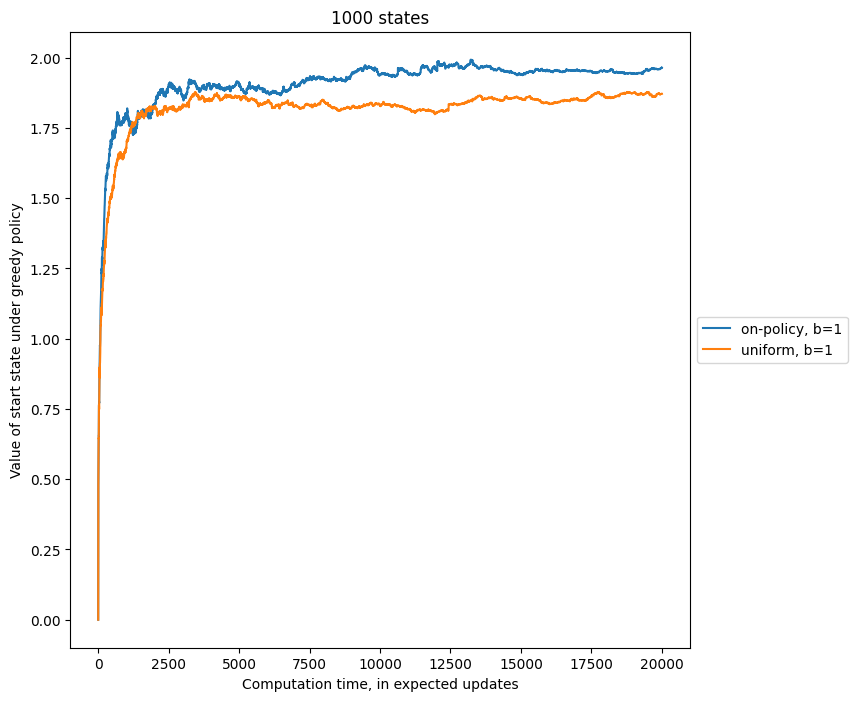

In [9]:
seed = 1
max_updates = 20000
n_states = 1000
tasks = 200
show_branching(
    title=f'{n_states} states',
    tasks=tasks,
    seed=seed,
    cases=[
        ('on-policy, b=1', lambda task_seed: test_case(n_states=n_states, plan_all=False, b=1, max_updates=max_updates, seed=task_seed)),
        # ('on-policy, b=3', lambda task_seed: test_case(n_states=n_states, plan_all=False, b=3, max_updates=max_updates, seed=task_seed)),
        # ('on-policy, b=10', lambda task_seed: test_case(n_states=n_states, plan_all=False, b=10, max_updates=max_updates, seed=task_seed)),

        ('uniform, b=1', lambda task_seed: test_case(n_states=n_states, plan_all=True, b=1, max_updates=max_updates, seed=task_seed)),
        # ('uniform, b=3', lambda task_seed: test_case(n_states=n_states, plan_all=True, b=3, max_updates=max_updates, seed=task_seed)),
        # ('uniform, b=10', lambda task_seed: test_case(n_states=n_states, plan_all=True, b=10, max_updates=max_updates, seed=task_seed)),
    ],
)

Last value of start state
seed 4813
[task: 1] on-policy, b=1: 2.184630345461169
seed 18019
[task: 2] on-policy, b=1: 3.1799330689280745
seed 14591
[task: 3] on-policy, b=1: 3.742632396267589
seed 2178
[task: 4] on-policy, b=1: 2.0850362135669487
seed 11167
[task: 5] on-policy, b=1: 1.4411939121244848
seed 18618
[task: 6] on-policy, b=1: 2.8747869052138335
seed 10536
[task: 7] on-policy, b=1: 2.058526538034153
seed 3556
[task: 8] on-policy, b=1: 1.591759462211852
seed 2938
[task: 9] on-policy, b=1: 2.981840690150335
seed 6603
[task: 10] on-policy, b=1: 2.462132920220009
seed 18144
[task: 11] on-policy, b=1: 1.0778257007286605
seed 3069
[task: 12] on-policy, b=1: 3.1299713861930862
seed 9334
[task: 13] on-policy, b=1: 1.273969432134558
seed 13728
[task: 14] on-policy, b=1: 2.2541678888018404
seed 8718
[task: 15] on-policy, b=1: 2.7246621139577836
seed 3027
[task: 16] on-policy, b=1: 2.6863899462715177
seed 3381
[task: 17] on-policy, b=1: 1.415924683225287
seed 18746
[task: 18] on-policy,

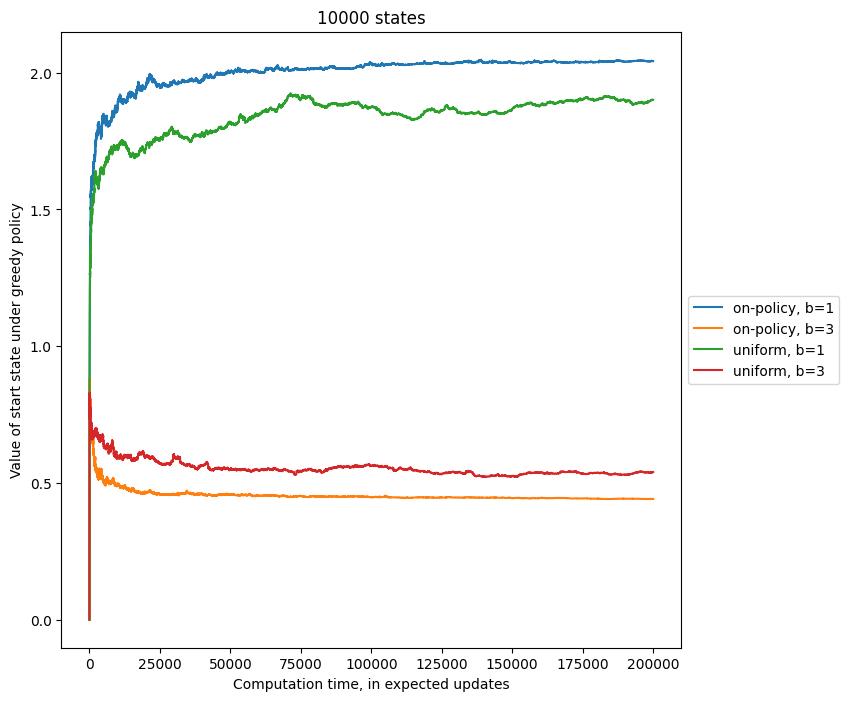

In [11]:
seed = 1
max_updates = 200000
n_states = 10000
tasks = 200
show_branching(
    title=f'{n_states} states',
    tasks=tasks,
    seed=seed,
    cases=[
        ('on-policy, b=1', lambda task_seed: test_case(n_states=n_states, plan_all=False, b=1, max_updates=max_updates, seed=task_seed)),
        ('on-policy, b=3', lambda task_seed: test_case(n_states=n_states, plan_all=False, b=3, max_updates=max_updates, seed=task_seed)),

        ('uniform, b=1', lambda task_seed: test_case(n_states=n_states, plan_all=True, b=1, max_updates=max_updates, seed=task_seed)),
        ('uniform, b=3', lambda task_seed: test_case(n_states=n_states, plan_all=True, b=3, max_updates=max_updates, seed=task_seed)),
    ],
)